# Hospital Length of Stay with SQL Machine Learning Services and revoscalepy

I have three tables of data stored on my SQL Server database "Hospital_Py": LengthOfStaySample, LengthOfStayTest, and LengthOfStayTrain. All of these tables contain patient characteristics and the number of days they stayed in the hospital.

I want to visualize this data, and train a model to predict the length of stay of future patients. But here's the catch, <i> the data in LengthOfStayTrain is not allowed to leave the machine</i>.

We can use SQL Server ML Services to execute Python code on our SQL Server and return the results to the client. This allows us to analyze our data on our SQL Server machine.

### The Goal: Visualize and analyze hospital length of stay data without it leaving the SQL machine.


## Visualize and explore the data

Our lawyers told us that the LengthOfStaySample table is the only table in this DB that can leave the SQL Server machine. We know it has the same schema as LengthOfStayTrain, so lets take a look at the sample just to know what we're dealing with.

In [4]:
import pandas as pd
import sqlalchemy
from urllib import parse
import os

sample_table = "LengthOfStaySample"
train_table = "LengthOfStayTrain"
test_table = "LengthOfStayTest"

server = os.environ["MY_SQL_HOSTNAME"]
uid = os.environ["MY_SQL_USER"]
pwd = os.environ["MY_SQL_PWD"]

connection_string = "Driver=SQL Server;Database=Hospital_Py;Uid={};Pwd={};Server={}".format(uid, pwd, server)
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(parse.quote_plus(connection_string)))

df_sample = pd.read_sql("select * from {}".format(sample_table), engine)

df_sample.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96.0,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61.0,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64.0,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76.0,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67.0,5.6,2,12/24/2012,E,4


### Histogram of Length of Stay

The bulk of the data we want to analyze is in the LengthOfStayTrain table. This data cannot leave the machine!

Lets plot a histogram that visualizes our target variable (lengthofstay). Since the data can't leave the machine, we need to use SQL ML Services to create the plot "In-DB".

We can use the revoscalepy function `rx_exec` to execute a Python function on a SQL server machine. In this code, we execute the function `plot_data` on SQL Server. The results of `plot_data` (the image data of the histogram visualization) is returned to our client machine.

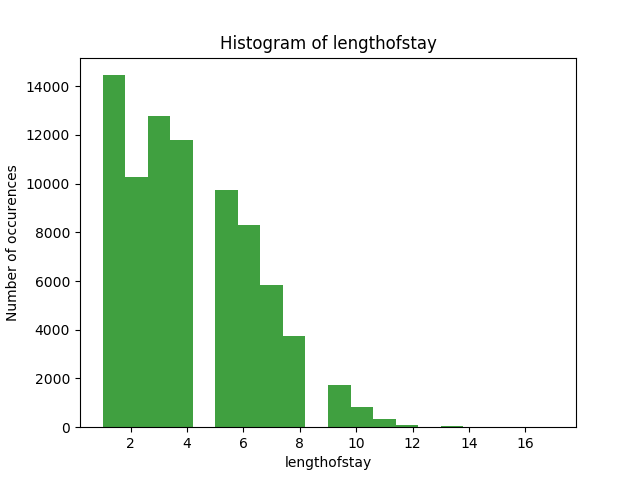

In [5]:
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
from IPython import display
from revoscalepy import RxInSqlServer, rx_exec

def plot_data(table_name):
    import pandas as pd
    import sqlalchemy
    from urllib import parse
    import matplotlib.pyplot as plt
    import io
    
    internal_connection_str = "Driver=SQL Server;Database=Hospital_Py;Trusted_Connection=Yes;Server=localhost"
    engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(parse.quote_plus(internal_connection_str)))
    df = pd.read_sql("select * from {}".format(table_name), engine)
    
    plt.hist(df["lengthofstay"], 20, facecolor='green', alpha=0.75)
    plt.title("Histogram of lengthofstay")
    plt.xlabel("lengthofstay")
    plt.ylabel("Number of occurences")
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    
    return buf.getvalue()


# Execute plot_data on the SQL machine
sql_compute_context = RxInSqlServer(connection_string=connection_string, console_output=True)
data_bytes = rx_exec(plot_data, table_name=train_table, compute_context=sql_compute_context)[0]
display.Image(data=data_bytes)

### Scatter plots of features vs. lengthofstay

Lets look at some scatter plots of our features versus lengthofstay. Once again, we use `rx_exec` so the data never leaves the machine.

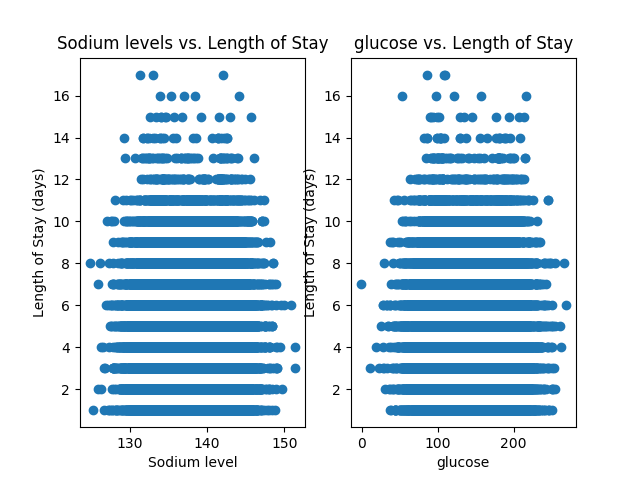

In [6]:
def scatter_plot(table_name):
    import pandas as pd
    import sqlalchemy
    from urllib import parse
    import matplotlib.pyplot as plt
    import io
    
    internal_connection_str = "Driver=SQL Server;Database=Hospital_Py;Trusted_Connection=Yes;Server=localhost"
    engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(parse.quote_plus(internal_connection_str)))
    df = pd.read_sql("select * from {}".format(table_name), engine)
    
    plt.subplot(121)
    plt.scatter(df["sodium"], df["lengthofstay"])
    plt.title("Sodium levels vs. Length of Stay")
    plt.xlabel("Sodium level")
    plt.ylabel("Length of Stay (days)")
    
    plt.subplot(122)
    plt.scatter(df["glucose"], df["lengthofstay"])
    plt.title("glucose vs. Length of Stay")
    plt.xlabel("glucose")
    plt.ylabel("Length of Stay (days)")
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    
    return buf.getvalue()

# Execute scatter_plot on the SQL machine
data_bytes = rx_exec(scatter_plot, table_name=train_table, compute_context=sql_compute_context)[0]
display.Image(data=data_bytes)

## Model training

Now lets train a model on our training data. Of course, we want this model training to happen In-DB.

We use a simple linear regression model from sklearn to fit our data, after preprocessing the features to their z-score values.

In [7]:
def train_linear_model(table, feature_names):
    import pandas as pd
    import sqlalchemy
    from urllib import parse
    from sklearn import linear_model
    
    internal_connection_str = "Driver=SQL Server;Database=Hospital_Py;Trusted_Connection=Yes;Server=localhost"
    engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(parse.quote_plus(internal_connection_str)))

    df_train = pd.read_sql("select * from {}".format(table), engine)
    
    lr = linear_model.LinearRegression()
    
    y = df_train["lengthofstay"]
    X = df_train[[feature_names]]
        
    lr.fit(X, y)
    return lr

features = ["sodium", "glucose", "creatinine", "bmi"]
# Execute train_linear_model on the SQL machine
linear_model = rx_exec(train_linear_model, 
                       table=train_table, 
                       feature_names=features, 
                       compute_context=sql_compute_context)[0]
print(linear_model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


## Prediction

Lets use the model to make predictions on our test data. Of course, the test data never leaves the machine. We store the predicted results in a new table "Predictions".

In [8]:
def predict_with_model(test_table, model, feature_names):
    import pandas as pd
    import sqlalchemy
    from urllib import parse
    from sklearn import linear_model
    
    internal_connection_str = "Driver=SQL Server;Database=Hospital_Py;Trusted_Connection=Yes;Server=localhost"
    engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(parse.quote_plus(internal_connection_str)))

    df_test = pd.read_sql("select * from {}".format(test_table), engine)
    
    lr = linear_model.LinearRegression()
    
    y_actual = df_test["lengthofstay"]
    X_test = df_test[[feature_names]]
    
    y_pred = model.predict(X_test)

    df_predictions = df_test[["lengthofstay", "eid"]]
    df_predictions["predicted_lengthofstay"] = y_pred
    
    df_predictions.to_sql(name="Predicted", con=engine, if_exists="replace")
    return df_predictions

predictions = rx_exec(predict_with_model,
                     test_table=test_table,
                     model=linear_model,
                     feature_names=features,
                     compute_context=sql_compute_context)[0]

predictions[["predicted_lengthofstay", "lengthofstay"]].head()

,predicted_lengthofstay,lengthofstay
0,3.997315,5
1,4.006667,2
2,4.006532,8
3,4.003705,1
4,4.005064,10


## Using a revoscalepy model 

The model shown above is very simple, and as you can see from the sample, its predictions aren't very good. We train another model using revoscalepy below. We pass a `sql_compute_context` to the `compute_context` parameter of `rx_btrees`, the model is trained on the SQL machine.


In [40]:
from revoscalepy import RxSqlServerData, rx_btrees, rx_get_var_names, rx_write_object, rx_read_object

sql_train = RxSqlServerData(connection_string = connection_string, table="LengthOfStayTrain", string_as_factors=True)

var_names = list(df_sample.columns.values)
variables_to_remove = ["eid", "vdate", "discharged", "facid", "lengthofstay"]

features = [x for x in var_names if x not in variables_to_remove]

formula = "lengthofstay ~ " + "+ ".join(features)

model_btrees = rx_btrees(formula, sql_train, n_tree=20, lr=0.3, cp=0.00005,
                         report_progress=0, compute_context=sql_compute_context)

# I can save the model to a SQL table
sql_models_table = RxSqlServerData(connection_string=connection_string, table="MyModels")
rx_write_object(dest=sql_models_table, key="MyBTreesModel", value=model_btrees)

# And easily retrieve the model from SQL
sql_models_table = RxSqlServerData(connection_string=connection_string, table="MyModels")
retrieved_model = rx_read_object(sql_models_table, key="MyBTreesModel")

Number of observations not available for this data source. 'numObs' set to 1e6.

For this data source, explicitly set 'max_num_bins' and 'min_split', otherwise innacurate models can result.
Please see rx_dtree 'max_num_bins' and 'min_split' for details.
Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0
, Total Chunk Time: 0.016 seconds 
Rows Read: 1, Total Rows Processed: 1, Total Chunk Time: 0.004 seconds 
